In [1]:
import pandas as pd
import glob
import scipy.io as io
import numpy
from tfcat import TFCat
from shapely.geometry import MultiPoint, Point, Polygon, MultiPolygon
from astropy.time import Time

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits import axes_grid1
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)


import h5py
from h5py import File
import numpy as np
from datetime import datetime
from os import path
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import csv
from tqdm import tqdm
import seaborn as sns 
from scipy.stats import binned_statistic_2d
from shapely.ops import unary_union

plt.rcParams["figure.figsize"] = (200,100)


/Users/clouis/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
def load_hdf5_data(file_name: str):
    """
    Reads a datafile in HDF5 format using the config file set earlier.
    """
    file: File = File(file_name)
    time = file['Time']
    freqs = file['Frequency']
    data = file['Data']
    return time, freqs, data

In [3]:
def distribution_latitude(data,time,freqs,ephemeris, type='occurrence'):
        bins = numpy.linspace(-90,90,181)
        distribution_occurrence = numpy.zeros(shape=(freqs.shape[0], len(bins)-1))
        distribution_intensity = numpy.zeros(shape=(freqs.shape[0], len(bins)-1))

        
        for i_freq in range(len(freqs)) :
            occurrence_mask = numpy.where(data[:, i_freq] > 0, numpy.ones_like(data[:,i_freq], dtype=bool), False)
            distribution_occurrence[i_freq, :]= numpy.histogram(ephemeris[occurrence_mask], bins=bins)[0]
            for i_index in range(len(bins)-1):
                latitude_mask = numpy.where(data[(ephemeris>=bins[i_index]) & (ephemeris < bins[i_index]+1), i_freq] > 0, numpy.ones_like(data[(ephemeris>=bins[i_index]) & (ephemeris < bins[i_index]+1),i_freq], dtype=bool), False)
                distribution_intensity[i_freq, i_index] =  numpy.mean(data[(ephemeris>=bins[i_index]) & (ephemeris < bins[i_index]+1), i_freq][latitude_mask])
        #for i_index in range(len(bins)-1):
        #    #latitude_mask = numpy.where((ephemeris>=bins[i_index]) and (ephemeris < bins[i_index]))
        #    for i_freq in range(len(freqs)):
        #        distribution_intensity[i_freq, i_index] = numpy.mean(data[numpy.where(data[(ephemeris>=bins[i_index]) & (ephemeris < bins[i_index]+1),i_freq]>0),i_freq])
        return distribution_occurrence, distribution_intensity

In [4]:
def normalization_factor_calculation(ephem):
    bins = numpy.linspace(-90,90,181)
    normalization_factor = numpy.histogram(numpy.array(ephem),bins=bins)[0]
    return normalization_factor

In [5]:
def polar_ephemeris_load(file, time_view_start, time_view_end, coordinate_system = "GSM"):
    df = pd.read_csv(file, delimiter = " ", header = None, skiprows=4,
                    names=["Date", "Time", "x_geo", "y_geo", "z_geo", "GEO_LAT", "GEO_LONG", "x_gm", "y_gm", "z_gm", "GM_LAT", "GM_LONG", "x_gse", "y_gse", "z_gse", "GSE_LAT", "GSE_LONG", "LT_gsm", "x_gsm", "y_gsm", "z_gsm", "GSM_LAT", "GSM_LONG", "Distance_R_E"])
    df["Date"] = "19"+df["Date"] 
    df.index = pd.to_datetime(df["Date"]+"T"+df["Time"])
    df.drop(["Date", "Time"], axis = 1, inplace = True)

    #Restricting flux and ephemeris data to be within the user defined start/end times
    
    df = df[(df.index > time_view_start) & (df.index < time_view_end)]

    date = numpy.array(Time(df.index).unix)
    latitude = numpy.array(df[coordinate_system+"_LAT"])
    longitude = numpy.array(df[coordinate_system+"_LONG"])
    distance = numpy.array(df["Distance_R_E"])
    return(date,latitude,longitude, distance)

In [6]:
def polar_ephemeris_load_xyz(file, time_view_start, time_view_end, coordinate_system = "GSM"):
    df = pd.read_csv(file, delimiter = " ", header = None, skiprows=4,
                    names=["Date", "Time", "x_geo", "y_geo", "z_geo", "GEO_LAT", "GEO_LONG", "x_gm", "y_gm", "z_gm", "GM_LAT", "GM_LONG", "x_gse", "y_gse", "z_gse", "GSE_LAT", "GSE_LONG", "LT_gsm", "x_gsm", "y_gsm", "z_gsm", "GSM_LAT", "GSM_LONG", "Distance_R_E"])
    df["Date"] = "19"+df["Date"] 
    df.index = pd.to_datetime(df["Date"]+"T"+df["Time"])
    df.drop(["Date", "Time"], axis = 1, inplace = True)

    #Restricting flux and ephemeris data to be within the user defined start/end times
    
    df = df[(df.index > time_view_start) & (df.index < time_view_end)]

    date = numpy.array(Time(df.index).unix)
    x = numpy.array(df["x_"+coordinate_system.lower()], dtype=float)
    y = numpy.array(df["y_"+coordinate_system.lower()], dtype=float)
    z = numpy.array(df["z_"+coordinate_system.lower()], dtype=float)

    return(date,x,y,z)

In [7]:
def plot_distribution(freqs, D, type='lat', intensity=False, occurrence=False, save_image=False, filename = "image", coordinate_system = "GSE", **kwargs):
    fs_labels = 15
    fs_ticks = 12
    fig = plt.figure(figsize = (5,5))
    ax = fig.gca()
    if type == 'lat':
        if intensity:
                vmin=np.quantile(D[D >0],0.25)
                vmax=np.quantile(D[D >0],0.99)
                scaleZ = colors.LogNorm(vmin=vmin,vmax=vmax)
                im = ax.pcolormesh(numpy.linspace(-90,89,180), freqs, D, cmap='viridis', norm=scaleZ, **kwargs)
        if occurrence:
            im = ax.pcolor(numpy.linspace(-90,89,180), freqs, D*100, cmap='viridis', **kwargs)
        
        ax.set_xlabel(coordinate_system+r' Latitude (°)', fontsize=fs_labels)
    elif type == 'long':
        im = ax.pcolor(numpy.linspace(-180,179,360), freqs, D*100, cmap='Spectral_r', **kwargs)
        ax.set_xlabel(r'Longitude (°)', fontsize=fs_labels)
    elif type == 'time' :
        im = ax.pcolor(numpy.linspace(0,24-24/360,360), freqs, D*100, cmap='Spectral_r', **kwargs)
        ax.set_xlabel(r'Local time (h)', fontsize=fs_labels)
    divider = axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes("right", size=0.15, pad=0.2)
    
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=20)
    
    
    #CBAR
    if occurrence == True:
        cb = fig.colorbar(im, cax=cax)
        cb.ax.tick_params(labelsize=fs_ticks)
        cb.ax.set_title('%', fontsize=fs_labels)
        ax.set_yticks([0, 10, 100])
    if intensity == True:
        cb = fig.colorbar(im, extend='both', shrink=0.9,cax=cax,ax=ax)
        cb.ax.tick_params(labelsize=fs_ticks)
        cb.set_label(r'V$^2$/m$^2$/Hz', fontsize=fs_labels)
        #ax.set_yticks([0, 10, 100])
    #AXIS
    #
    
    ax.set_ylabel(r'Frequency (kHz)', fontsize=fs_labels)
    ax.set_yscale('log')
    #ax.yaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.xaxis.label.set_size(fs_labels)
    ax.yaxis.label.set_size(fs_labels)

    
   
    plt.tight_layout()
    
    if save_image:
        plt.savefig(filename+'.png', dpi=500)
    return fig, ax, cb

In [8]:
def plot_dynamic_spectrum(time, freqs, flux, save_image=False, filename = "image", **kwargs):
    fs_labels = 15
    fs_ticks = 12
    fig = plt.figure(figsize = (10,5))
    ax = fig.gca()
    
    vmin=np.quantile(flux[flux >0],0.05)
    vmax=np.quantile(flux[flux >0],0.95)
    scaleZ = colors.LogNorm(vmin=vmin,vmax=vmax)

    im = ax.pcolormesh(time, freqs, flux, cmap='viridis', norm=scaleZ, **kwargs)
    ax.set_xlabel(r'Time', fontsize=fs_labels)
    
    major_locator=mdates.HourLocator(interval=6) #toutes les 6 heures
    minor_locator=mdates.HourLocator(interval=1)
    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_minor_locator(minor_locator)
    dateFmt = mdates.DateFormatter('%Y/%m/%d\n%H:%M')
    ax.xaxis.set_major_formatter(dateFmt)
    
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right",size="5%",pad=0.10)
    divider = axes_grid1.make_axes_locatable(ax)
    cax = divider.append_axes("right", size=0.15, pad=0.2)
    
    
    #CBAR
    cb = fig.colorbar(im, extend='both', shrink=0.9,cax=cax,ax=ax)
    #cb = fig.colorbar(im, cax=cax)
    cb.ax.tick_params(labelsize=fs_ticks)
    cb.set_label(r'V$^2$/m$^2$/Hz', fontsize=fs_ticks)
    ax.set_yticks([0, 10, 100])
    
    #AXIS
    #
    
    ax.set_ylabel(r'Frequency (kHz)', fontsize=fs_ticks)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(FormatStrFormatter("%d"))

    plt.tight_layout()
    if save_image:
        plt.savefig(filename+'.png', dpi=500)

    return fig, ax, cb

In [9]:
#path to ephemeris and save directory:
dir_save_name = "/Users/clouis/Documents/Data/POLAR/data"
#Polar ephemeris data taken from https://sscweb.gsfc.nasa.gov/cgi-bin/Locator.cgi
data_path_ephemeris = glob.glob("/Users/clouis/Documents/Data/POLAR/data/polar_ephemeris_geo_gm_gse_gsm.txt")[0]
path_masked_data = "/Users/clouis/Documents/Data/POLAR/data/polar_all_features_mask.hdf5"


# time window to work with
time_view_start = '1996-03-25'
time_view_end ='1996-05-03'
(time_data, freqs_data, masked_data) = load_hdf5_data(path_masked_data)

In [18]:
Time(numpy.max(time_data), format="unix").isot

'1996-05-02T23:59:51.730'

/Users/clouis/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/clouis/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-7-ab51499b4dfd>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(numpy.linspace(-90,89,180), freqs, D*100, cmap='viridis', **kwargs)
<ipython-input-7-ab51499b4dfd>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y,

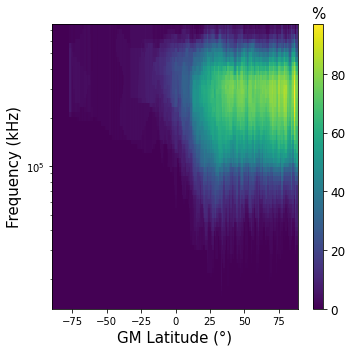

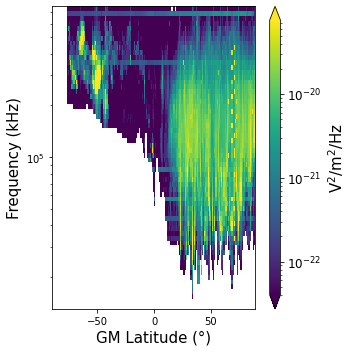

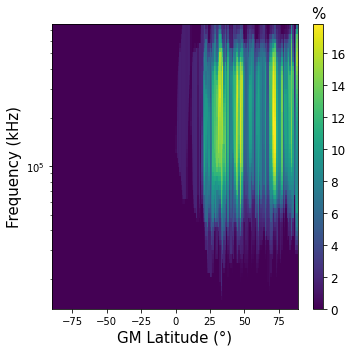

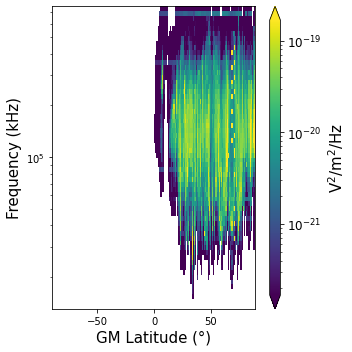

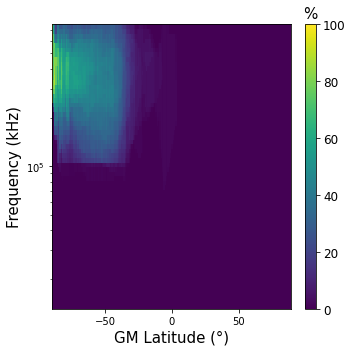

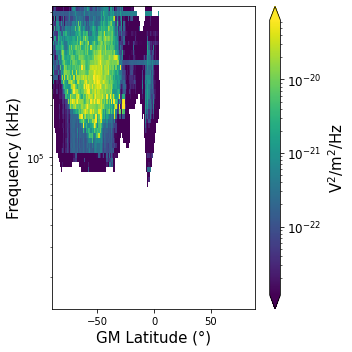

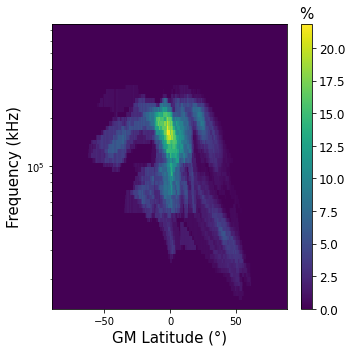

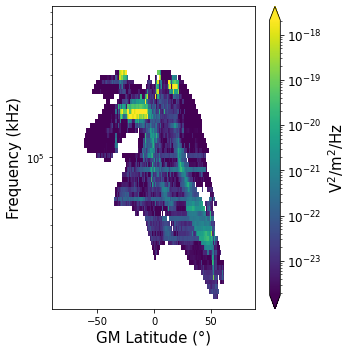

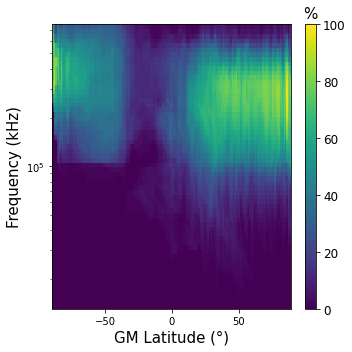

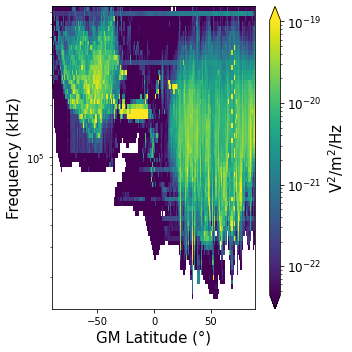

In [9]:
#path to ephemeris and save directory:
dir_save_name = "/Users/clouis/Documents/Data/POLAR/data"
data_path_ephemeris = glob.glob("/Users/clouis/Documents/Data/POLAR/data/polar_ephemeris_geo_gm_gse_gsm.txt")[0]

# time window to work with
time_view_start = '1996-03-25'
time_view_end ='1996-05-03'

i_coordinate_system=0

#coordinate_system_table = ["GSE", "GEO", "GSM"]
coordinate_system_table = ["GM"]
for coordinate_system in coordinate_system_table:
    
    i_coordinate_system = i_coordinate_system+1
    
    for i_feature in range(5):

        # feature to work with & masked data path
        if i_feature == 0:
            type_ = ["AKR"]
            type_feature = "AKR"
            path_masked_data = "/Users/clouis/Documents/Data/POLAR/data/polar_"+type_[0]+"_mask.hdf5"
        if i_feature == 1:
            type_ = ["LFE"]
            type_feature = "LFE"
            path_masked_data = "/Users/clouis/Documents/Data/POLAR/data/polar_"+type_[0]+"_mask.hdf5"
        if i_feature == 2:
            type_ = ["HAKR"]
            type_feature = "HAKR"
            path_masked_data = "/Users/clouis/Documents/Data/POLAR/data/polar_"+type_[0]+"_mask.hdf5"
        if i_feature == 3:
            type_ = ["FCE"]
            type_feature = "FCE"
            path_masked_data = "/Users/clouis/Documents/Data/POLAR/data/polar_"+type_[0]+"_mask.hdf5"
        if i_feature == 4:
            type = ["all"]
            type_feature = "ALL"
            path_masked_data = "/Users/clouis/Documents/Data/POLAR/data/polar_all_features_mask.hdf5"

        

        # load masked data
        (time_data, freqs_data, masked_data) = load_hdf5_data(path_masked_data)

        # sorted data to avoid issue later

        sorted_time, sorted_data = zip(*sorted(zip(time_data, masked_data)))
        del time_data, masked_data
        time_data, masked_data = numpy.array(sorted_time), numpy.array(sorted_data)

        # load ephemeris
        (date_ephem,latitude,longitude,distance) = polar_ephemeris_load(data_path_ephemeris, time_view_start, time_view_end,coordinate_system=coordinate_system)

        #Interpolating the ephemeris data so it lines up with the flux data
        longitude = numpy.array(numpy.interp(time_data, date_ephem, longitude))
        latitude = numpy.array(numpy.interp(time_data, date_ephem, latitude))
        distance = numpy.array(numpy.interp(time_data, date_ephem, distance))
        date_ephem = numpy.array(numpy.interp(time_data, date_ephem, date_ephem))

        # Normalizing @ 1 AU
        RE = 6371.0
        AU = 149597870.700 # 1 astronomical unit
        for i_freq in range(len(freqs_data)):
            masked_data[:, i_freq] = masked_data[:,i_freq]*(distance*RE/AU)**2

        # calculating occurence and intensity distribution
        distribution_occurrence,distribution_intensity = distribution_latitude(masked_data,time_data,freqs_data, latitude)

        # calculating normalization factor
        normalization_factor = normalization_factor_calculation(latitude)

        time_new = Time(time_data[0:5760],format="unix").tt.datetime
    
        if i_coordinate_system ==0:
            filename = "dynamic_spectrum_19960325_"+type_feature
            plot_dynamic_spectrum(time_new, freqs_data, masked_data[0:5760,:].T, save_image=True, filename=filename)

        filename = "lat_distribution_occurrence_"+type_feature+"_"+coordinate_system
        plot_distribution(freqs_data, distribution_occurrence/normalization_factor, save_image=True, filename=filename, occurrence=True, coordinate_system=coordinate_system)

        filename = "lat_distribution_intensity_"+type_feature+"_"+coordinate_system
        plot_distribution(freqs_data, distribution_intensity, save_image=True, filename=filename, occurrence= False, intensity=True, coordinate_system=coordinate_system)